<a href="https://colab.research.google.com/github/lcduquev/Analisis-Numerico/blob/master/Mapeo_de_celdas_para_control_%C3%B3ptimo_del_doble_integrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapeo de celdas para control óptimo del doble integrador

<font size="-1">**Resumen**: en el presente documento se pretende solucionar el problema de control óptimo de un doble integrador utilizando la teoría de grafos y la librería NetworkX de Python, mostrando todo el proceso de construcción del grafo para posteriormente solucionar un problema de aplicación con la red generada para comparar los resultados con la solución analítica. </font>


## Contenido del documento

* [1. Introducción y descripción del problema](#chapter1)
* [2. Marco teórico](#chapter1.1)
  * [2.1. Control óptimo](#chapter1.2)
    * [2.1.1 Problemas de control óptimo](#chapter1.3)
  * [2.2 Solucionadores analíticos vs numéricos](#chapter1.4)
  * [2.3 Aproximación numérica mediante el mapeo de celdas](#chapter2)
    * [2.3.1 Sobre la teoría de grafos](#chapter2.1)
    * [2.3.2 El integrador doble en forma de grafo](#section_2_1)

* [3. Restricciones para modelo](#chapter3)
* [4. Paso a paso de la construcción del grafo](#chapter_4)
  * [4.1 Exploración gráfica del integrador doble](#chapter4)
    * [4.1.1 Análisis del espacio de estados](#chapter4.1)
  * [4.2 Construcción de la plantilla o template](#chapter4.2)
  * [4.3 Construcción del grafo](#chapter5)
* [5. Solución analítica de un problema de control óptimo](#chapter9)
  * [5.1 Modelo dinámico de una partícula](#chapter9.1)
  * [5.2 Diseño de la señal de control óptima](#chapter9.2)
  * [5.3 Ejemplo](#chapter9.3)
* [6. Solución de un problema de control óptimo mediante el mapeo de celdas](#chapter6)
* [7. Análisis de los resultados](#chapterr)
* [8. Conclusiones y discusión](#chapter7)
* [9. Referencias](#chapter8)
  

<a name="chapter1"></a>

## 1. Introducción y descripción del problema 

Muchos sistemas físicos, químicos y económicos pueden ser modelados por relaciones matemáticas, tales como ecuaciones diferenciales o de diferencias ya sean determinísticas o estocásticas.

Estos sistemas pueden ser llevados de un estado a otro aplicando una fuerza externa. Si hay diferentes maneras de realizar este cambio de estados se hace necesario escoger la mejor en términos de la variable que nos interese **minimizar o maximizar**, como lo podría ser el consumo energético.

En la teoría de sistemas y control, el **integrador doble** es un ejemplo canónico de un sistema de control de segundo orden que modela la dinámica de una masa simple en un espacio unidimensional bajo el efecto de una entrada de fuerza variable en el tiempo $u$.

El integrador doble es un [modelo matemático para un automóvil en movimiento rectilíneo sobre un plano plano y sin fricción](https://www.researchgate.net/publication/330132751_Optimal_control_of_double_integrator_with_minimum_total_variation) como el de la siguiente figura. También constituye un modelo para sistemas eléctricos y rotacional-mecánicos análogos. Debido a su simplicidad, el control óptimo del integrador doble se estudia virtualmente en cada curso sobre la teoría del control óptimo, donde se buscan [soluciones analíticas](https://www.marcoteorico.com/curso/87/matematicas-para-la-toma-de-decisiones/712/solucion-analitica-) para los **problemas de minimización del esfuerzo y tiempo de control**. 

<img align="left" src="https://drive.google.com/uc?export=view&id=1sONH3WNjMympRhLOBGkrswSwOsSGKeiO" width="450" height="200" alt="carrito" >

$y(t) \rightarrow$ posición del carrito.

$\dot y(t) \rightarrow$ velocidad del carrito.

Por la segunda ley de Newton,  $\ddot y(t)=u(t)$, donde $u(t)$ es la sumatoria de todas las fuerzas ejercidas sobre el carrito. En este caso, representa solamente la aceleración y desaceleración del mismo.

Este modelo se llama integrador doble ya que se puede obtener $y(t)$ al integrar $u(t)$ dos veces.

<font size="-1"> Figura 1: modelo físico simplificado de un automóvil como una masa puntual. Tomada de [Optimal control of double integrator with minimum total variation, C. Yalçın Kaya](https://www.researchgate.net/publication/330132751_Optimal_control_of_double_integrator_with_minimum_total_variation)

Como ya se mencionó, el modelo es simple, sin embargo encontrar la solución analítica para esa óptima fuerza externa o señal de control se puede volver más complejo entre más complicado se vuelvan los sistemas. Una buena manera de sortear está dificultad de encontrar la solución óptima mediante el uso de herramientas del [análisis numérico](https://es.wikipedia.org/wiki/An%C3%A1lisis_num%C3%A9rico), que en este caso es una aproximación numérica lograda mediante la construcción de una red mediante el mapeo de celdas que, en pocas palabras, utiliza la dinámica de solucionar el problema por camino más corto.

<a name="chapter1.1"></a>
## 2. Marco teórico

<a name="chapter1.2"></a>
## 2.1 Control óptimo

El control óptimo solicita calcular una función de control (ya sea en [bucle abierto o en bucle cerrado](https://controlautomaticoeducacion.com/control-realimentado/lazo-abierto-y-lazo-cerrado/)) que optimiza alguna métrica de rendimiento con respecto al control y al estado previsto. Por ejemplo, a un conductor de un automóvil le gustaría llegar a una ubicación deseada mientras logra varios otros objetivos: evitar obstáculos, no conducir erráticamente, mantener un nivel cómodo de aceleraciones para los pasajeros . Un estilo de conducción puede estar compuesto por una combinación equilibrada de estos objetivos. El control óptimo permite que un diseñador de control especifique el [modelo dinámico](http://www.exa.unne.edu.ar/informatica/anasistem2/public_html/apuntes/maf/anexos/dinamico.htm#:~:text=El%20Modelo%20Din%C3%A1mico%20consiste%20en,%20o%20no%20(concurrentes)) y los resultados deseados, y el algoritmo calculará un control optimizado. Esto alivia un poco la carga al permitir que el diseñador razone al nivel de lo que debería hacer el robot, en lugar de diseñar cómo debería hacerlo.

<a name="chapter1.3"></a>
### 2.1.1 Problemas de control óptimo

Un problema de control óptimo está definido por la función dinámica  $f$ y un costo funcional a lo largo de toda la trayectoria $x$  y  $u$ :

\begin{equation}
J(x,u) = \int_0^\infty L(x(t),u(t),t) dt
\end{equation}

El término *funcional* indica que se trata de una **función que asigna una función a un número real**. El termino $L ( x , u , t )$ se conoce como el costo instantáneo (o costo de funcionamiento) que se acumula en el tiempo y debe elegirse para que no sea negativo y penalice ciertos estados, velocidades o controles no deseados. Sus unidades son costo por segundo.

**El objetivo del control óptimo** es encontrar el estado y las trayectorias de control $x$  y  $u$  tal que  $J( x , u )$  se minimiza:

\begin{equation}
\begin{gathered}
x^\star, u^\star = \arg \min_{x,u} J(x,u) \text{ tal que} \\
\dot{x}(t) = f(x(t),u(t)) \text{ para todo }t
\end{gathered}
\end{equation}

Por razones algo técnicas, hay problemas para los que no existe una trayectoria óptima, sino solo una secuencia de trayectorias que se acercan a un costo óptimo. Por lo tanto, si preferimos ser pedantes, a menudo es necesario probar primero la existencia de una solución óptima, o flexibilizar el problema para determinar solo un óptimo aproximado.

Por lo general, los solucionadores de control óptimos requieren que el costo funcional sea uniforme, por lo que las restricciones no diferenciables como el tiempo mínimo y la evitación de obstáculos deben reformularse como restricciones estrictas, externas al costo funcional. Como resultado, la reformulación se convierte esencialmente en un problema de optimización con restricciones de dimensión infinita. Los solucionadores pueden diferir acerca de si pueden manejar restricciones de estado o restricciones de control.

<a name="chapter1.4"></a>
## 2.2 Solucionadores analíticos vs numéricos 

La minimización en un espacio de funciones es considerablemente más difícil de resolver que los problemas típicos de optimización: el espacio de funciones es infinito en dimensiones. Hay dos formas generales de abordar estos problemas: analítica o numérica. Las técnicas analíticas utilizan las condiciones matemáticas de optimización para que el control óptimo se pueda determinar directamente a través del cálculo y la manipulación algebraica. La aplicación exitosa del análisis generalmente requiere una dinámica y un costo relativamente simples. Las técnicas numéricas aproximan el problema al [discretizar](https://es.wikipedia.org/wiki/Discretizaci%C3%B3n) el estado, el tiempo y / o el espacio de control e intentan presentar el problema como una optimización dimensional finita. Estos son de uso más general y se pueden aplicar a problemas complejos, pero son más costosos desde el punto de vista computacional y generalmente requieren algunos ajustes de parámetros para obtener soluciones de alta calidad.

<a name="chapter2"></a>
## 2.3 Aproximación numérica mediante el mapeo de celdas

Los métodos de mapeo de celdas describen la dinámica del sistema mediante mapeos de celda a celda discretizando tanto el [espacio de estados](https://es.wikipedia.org/wiki/Espacio_de_estados) como el tiempo. Para realizar esta discretización se divide el espacio de estados en un set de pequeñas celdas, y para resolver este problema de forma computacional en este documento nos valdremos de la teoría de grafos para realizar el mapeo de dichas celdas. 

<a name="chapter2.1"></a>
### 2.3.1 Sobre la teoría de grafos 


La teoría de grafos es el estudio de objetos matemáticos conocidos como grafos, que consisten en **vértices** (o *nodos*)   <img align="right" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/250px-6n-graf.svg.png" width="220" height="150" alt="grafo" > conectados por **bordes**. En la figura los vértices son los círculos numerados y los bordes se unen a los vértices.

Cualquier escenario en el que se desee examinar la estructura de una red de objetos conectados es potencialmente un problema para la teoría de grafos. Los ejemplos de teoría de grafos surgen con frecuencia no solo en matemáticas sino también en física e informática.

Para esta aplicación no es relevante conocer a profundidad la teoría de grafos, pero si está interesado en el tema puede leer más [aquí](https://www.analyticsvidhya.com/blog/2018/09/introduction-graph-theory-applications-python/).

<font size="-1"> Figura 2: ejemplo de la representación gráfica de un grafo. Tomado de [Graph theroy](https://en.wikipedia.org/wiki/Graph_theory)

<a name="section_2_1"></a>

### 2.3.2 Representando el integrador doble como grafo

En el grafo que vamos a generar, los nodos van a representar todos los posibles puntos del espacio de estados, mientras que los bordes van a ser los caminos que los conectan, donde cada camino va a tener un **peso** relacionado con la función que queremos optimizar, ya sea el esfuerzo o el tiempo en este caso.


 <a name="chapter3"></a>
 ## 3. Restricciones para modelo 

Las ecuaciones diferenciales que representan un integrador doble son:

$$\dot x_1 = x_2$$
$$\dot x_2 = u_k$$

En esta representación, está claro que la entrada de control $u$ es la segunda derivada de la salida $x_1$.

Como la señal de control se produce para modificar la variable controlada de tal forma que se disminuya o elimine el error, vamos a crear una restricción para esta, de forma tal que esté acotada en un rango y que tenga forma de delta de Dirac:

$$u_k \in Q_\delta(u),~\text{with}~ Q_\delta(u)=\delta  \lfloor \frac{u}{\delta}\rfloor,~k=\lfloor \frac{u}{\delta} \rfloor,~u\in[u_{min},u_{max}]$$

El tiempo en el que se evalúe el punto inicial debe ser menor al tiempo en el que se evalúe el punto final (optimizado).

$$(x_1(t_i),x_2(t_i))=(x_{1,i},x_{2,i})$$
$$(x_1(t_j),x_2(t_j))=(x_{1,j},x_{2,j})$$
$$t_i<t_j$$

 <a name="chapter_4"></a>
## 4. Paso a paso de la construcción del grafo
 


 <a name="chapter4"></a>
### 4.1 Exploración gráfica del integrador doble 

El primero paso para construir el grafo es estudiar gráficamente el integrador doble bajo las restricciones descritas anteriormente. Esto ayudará a encontrar algunas propiedades facilitarán la construcción del grafo y el entendimiento del mismo. 


##### Se importan todas las librerías necesarias para el desarrollo del proyecto

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from scipy.integrate import solve_ivp
from scipy.linalg import expm as exp
from scipy.integrate import trapz
from time import time
import networkx as nx 
from math import floor

from IPython.display import clear_output

##### Definición del doble integrador como función en Python

In [2]:
def double_integrator(t,x,u):
    return [x[1],u]

##### Definición del set de señales de control

Como se mencionó en la sección anterior, para resolver el problema mediante un grafo se va a tener un conjunto definido de señales de control. En este caso la señal de control puede tomar cualquier magnitud entera entre -4 y 4, por lo que van a haber 9 posibles señales de control (contando el 0).

Text(0.5, 1.0, 'Conjunto de posibles señales de control')

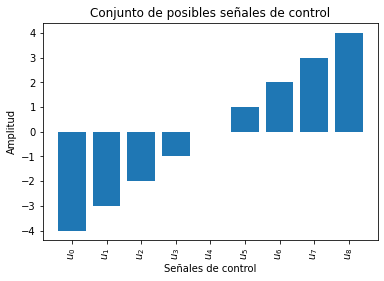

In [3]:
du = 1
u_set = [-4,4]
u_k = np.arange(u_set[0],u_set[1]+du,du)
plt.bar(['$u_{}$'.format(i) for i in np.arange(len(u_k))],u_k,width=0.8)
plt.xticks(rotation = 90)
plt.ylabel('Amplitud')
plt.xlabel('Señales de control')
plt.title('Conjunto de posibles señales de control')

 <a name="chapter4.1"></a>
##### 4.1.1 Análisis del espacio de estados 

Es necesario conocer el espaciamiento en el eje x y el eje y ($dx , dy$) para construír una plantilla que mapee los posibles estados y posteriormente con ella construír el grafo. Para encontrar estos diferenciales lo primero que se hará es graficar el espacio de estados sin condiciones iniciales y aplicando cada señal de control 0.1 segundos.

El esparcimiento de los ejes es:  0.005 en x y  0.1 en y


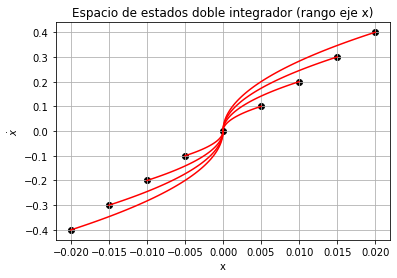

In [4]:
dt = 0.1 # tiempo de aplicación mínimo de cada señal de control 

x0 = [0,0] # condiciones iniciales = 0 
tspan = [0,dt] # periodo de integración 

#para cada posible señal de control, resolver el doble integrador y graficar el espacio de estados
for u in u_k:
    sol = solve_ivp(double_integrator,tspan,x0,args=(u,),dense_output=True) 
    t = np.linspace(0,tspan[1],endpoint=True)
    x = sol.sol(t)
    plt.scatter(x[0,-1],x[1,-1],c='k')
    plt.plot(x[0,:],x[1,:],'r')
    plt.title('Espacio de estados doble integrador (rango eje x)')
    plt.xlabel('x')
    plt.ylabel('$\dot{x}$')
plt.grid()

# calcular el esparcimiento de los ejes
dx = x[0,-1]/4
dy = x[1,-1]/4

# redondear para evitar problemas cuando se tienen muchos decimales 
dx = abs(np.round(dx,3))
dy = abs(np.round(dy,3))

print("El esparcimiento de los ejes es: ",dx, "en x y ",dy, "en y")

Como la gráfica del espacio de estados anterior se realizó bajo la premisa de que no existen condiciones iniciales, el próximo paso es analizar qué pasa si estas se presentan.

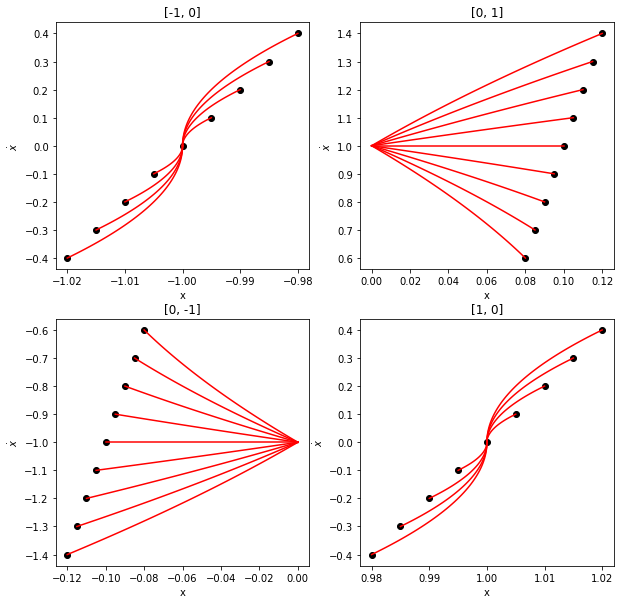

In [5]:
# Definir una función para resolver el doble integrador
def plot_plantilla(double_integrator,u_k,x0= [0,0],tspan=[0,dt],color='r',trayectory=True):
    for u in u_k:
        sol = solve_ivp(double_integrator,tspan,x0,args=(u,),dense_output=True) 
        t = np.linspace(0,tspan[1],endpoint=True)
        x = sol.sol(t)
        plt.scatter(sol.y[0,-1],sol.y[1,-1],c='k')
        if trayectory:
            plt.plot(x[0,:],x[1,:],color)

# Definir algunas condiciones iniciales             
x0s = [[-1,0],[0,1],[0,-1],[1,0]]

# Organizar las gráficas
plt.figure(figsize=(10,10))
for i,x0 in enumerate(x0s):
    plt.subplot(2,2,i+1)
    plt.title('{}'.format(x0))
    plt.xlabel('x')
    plt.ylabel('$\dot{x}$')
    plot_plantilla(double_integrator,u_k,x0)

De las gráficas anteriores es posible deducir dos cosas. Primero, se produce un cambio de forma en el espacio de estados cuando varía la condición inicial en el eje $y$; segundo, es observable que el distanciamiento entre puntos adyacentes es igual para todos los puntos.

Es importante recordar que estos puntos crean un límite en el espacio de estados, por lo que los estamos explorando para acotar los puntos con las que construiremos nuestro grafo (nodos).

Las observaciones anteriores permiten inferir que para crear la plantilla o template es necesario variar la posición del estado inicial solo en el eje $y$ con un $dy$ de espaciamiento. Esto es debido a que la forma de la figura que cambia cando se mueve en el eje $y$, pero no cambia cuando se desplaza en el eje $x$.

##### Plantilla o template

Ahora se define el rango del eje $y$ deseado. Aquí se escoge un rango pequeño ($[-2,2]$) debido al coste computacional.

In [6]:
#Definir el rango para el eje y con un esparcimiento de dy (0.1)
y_min,y_max = -2,2
rango_y = np.arange(y_min,y_max,dy)

Text(0, 0.5, '$\\dot{x}$')

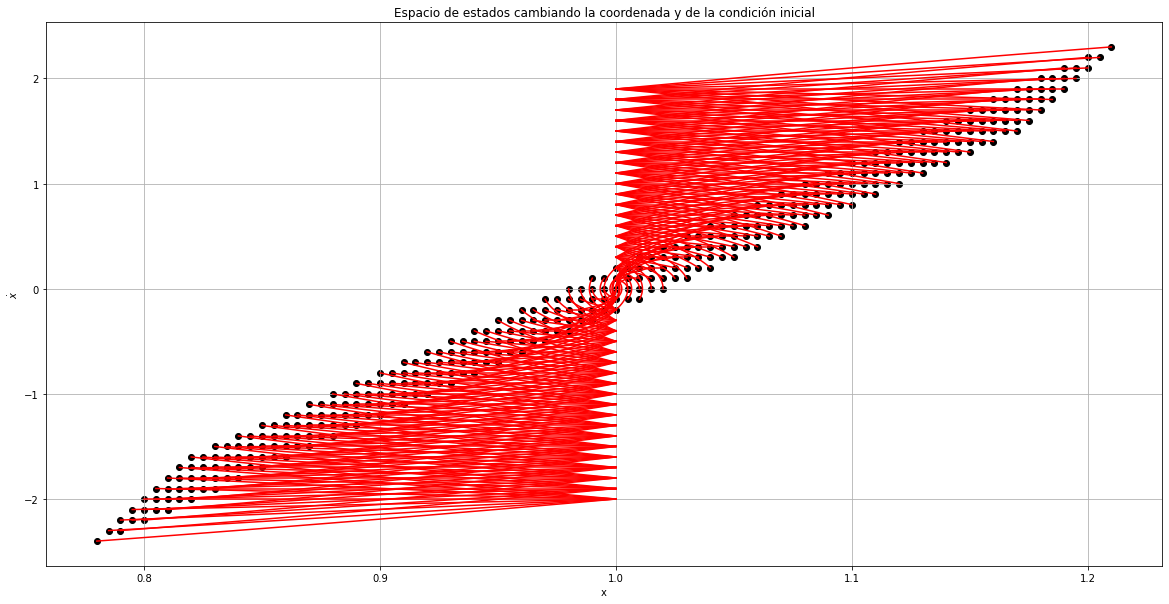

In [7]:
# Graficar el espacio de estados para este nuevo rango utilizando la misma función que antes, cambiando solamente la coordenada y de la condición inicial
plt.figure(figsize=(20,10))
for i in rango_y:
    plot_plantilla(double_integrator,u_k,x0=[1,i],color='r',trayectory =True)
plt.grid()
plt.title('Espacio de estados cambiando la coordenada y de la condición inicial')
plt.xlabel('x')
plt.ylabel('$\dot{x}$')

 <a name="chapter4.2"></a>

### 4.2 Construcción de la plantilla

La **plantilla** es una representación matricial de la figura anterior que va a tener los siguientes campos: 


Columna 1|Columna 2|Columna 3|Columna 4| Columna 5
:---|:---|:---|:---|:---
Nodo inicial x | Nodo inicial y | Nodo final x | Nodo final y | Señal de control $u$

Esta matriz **representa la trayectoria de un nodo inicial (condición inicial) al nodo final(condición final) que se logra poniendo la señal de control especificada en la quinta columna al sistema**.

In [8]:
# Definir la función para generar la plantilla basados en la gráfica anterior 

def Tplantilla(double_integrator,u_k,altura,tspan=[0,dt]):
    template = np.zeros((len(altura)*len(u_k),5)) #crear un arreglo de ceros 
    contador = 0
    for j,alt in enumerate(altura):   # para cada punto del rango en y se varía la condición inicial
        x0 = [0,alt]
        for i,u in enumerate(u_k):
            sol = solve_ivp(double_integrator,tspan,x0,args=(u,),dense_output=True)   # solución del doble integrador
            t = np.linspace(0,tspan[1],endpoint=True)
            x = sol.sol(t)
            template[contador,...] = x0[0],x0[1],sol.y[0,-1],sol.y[1,-1],u  #crear la plantilla con la estructura que se mencionó en el cuadro anterior
            contador += 1
    return template

In [9]:
# Generar la plantilla definitiva
template = Tplantilla(double_integrator,u_k,rango_y) #(begin_node_x,begind_node_y,end_node_x,end_node_y,u_signal)

# Redondear los números porque estos serán las etiquetas de cada nodo en el grafo
template[0,:] = np.round(template[0,:],3)  
template[2,:] = np.round(template[2,:],3) 
template[1,:] = np.round(template[1,:],1) 
template[3,:] = np.round(template[3,:],1) 

print (template.shape)

(360, 5)


##### Espacio de trabjo 

Ahora se quiere visualizar el espacio de trabajo. El espacio de trabajo representa todos los valores posibles que van a poder representarse en el grafo dados deltas de cada eje.  


In [10]:
# El eje x puede tener o crear los puntos que desee, mientras que el eje y está restringido por el máximo de los 
# puntos del template, eso se explica por la gráfica, ya que es posible moverla libremente por el eje x y sin afectar su 
# forma pero eso no sucede con el eje y 

Nx = 400 #número de puntos eje x N_x*2 + 1
Ny = 20 #número de puntos eje y N_y*2 + 1 
x1s = np.round(np.arange(-dx*Nx,dx*Nx+dx,dx),3) #las cifras decimales dependen de los delta de cada eje 
x2s = np.round(np.arange(-dy*Ny,dy*Ny+dy,dy),1)
len(x1s)*len(x2s) # cantidad total de puntos posibles en el espacio de trabajo

32841

In [11]:
X,Y = np.meshgrid(x1s,x2s)

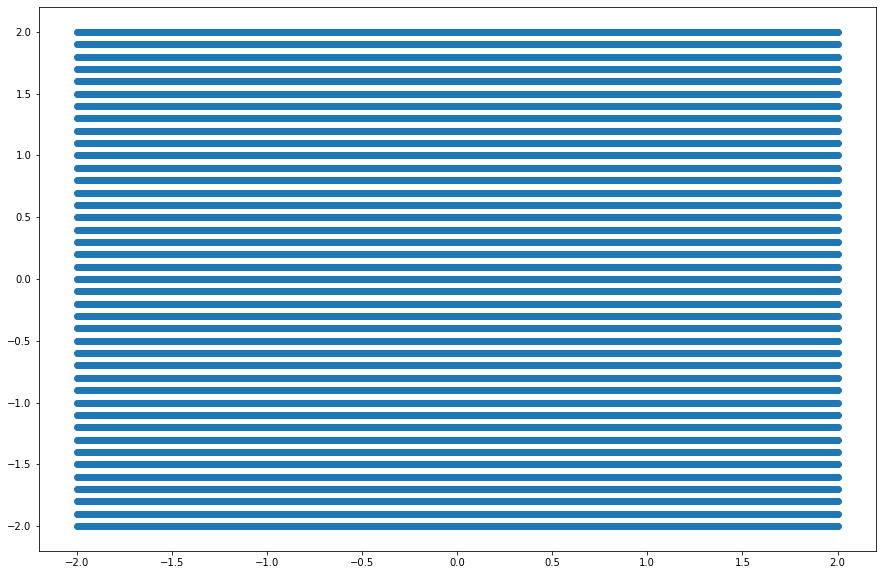

In [12]:
plt.figure(figsize=(15,10))
plt.scatter(X,Y)

 <a name="chapter5"></a>
### 4.3 Construcción del grafo 
Cada punto del espacio de trabajo se mira principalmente como un punto final para crear el grafo, las preguntas que siempre se hacen son, ¿desde qué puntos puedo llegar a un punto especifico? y ¿qué señal de control me permite esto?; con esas dos preguntas en mente se monta el grafo.

Las etiquetas que se le asignaron a cada nodo (que representa un punto en el espacio de estados) son las coordenadas del punto, esto por facilidad a la hora de consultar en el grafo, aunque acarrea realizar aproximaciónes o redondeos para evitar duplicación de nodos.

Cada punto del espacio de trabajo va a ser un nodo, pero no van a ser los únicos ya que pueden haber puntos fuera del espacio de trabajo que conduzcan a nodos que sí estén dentro del espacio. Estos puntos fuera del espacio de trabajo solo van a poder ser puntos iniciales, nunca funales no finales, en cambio, si todo va bien con el grafo, los puntos del espacio de trabajo podran ser iniciales y finales.

Con esto en mente se comienza a construir el grafo. El primer paso es iterar sobre cada punto del espacio de trabajo, preguntando en cada uno qué puntos o nodos llegan a él; pero cuidado hay muchos puntos fuera del template. Para solucionar esto es necesario recordar lo que se habla desde el inicio: podemos correr el template en el eje $x$ sin que el espacio de estados cambie su forma, entonces esto es lo que se hace: mover el template en ese eje de tal manera que el punto que se está analizando entre en él. 

Finalmente, con la librería NetworkX se conecta el punto final que se esté analizando con todos los puntos iniciales posibles agregándole a cada camino o borde un peso relacionado con el esfuerzo de control $u^2$

In [13]:
# Construcción del grafo utilizando la librería NetrowkX 

G = nx.DiGraph() # Definir el grafo

start = time()
contador = 1

# realizar el proceso para cada punto del espacio de trabajo
for x1 in x1s: 
    for x2 in x2s:
        new_point =[x1,x2]      # crear un punto final nuevo
        
        # se toman los nodos finales en y de la plantilla y se los llama superpunto, se hace = x2 de esta iteración
        super_point = template[np.round(template[:,3],1) == new_point[1]] 

        # mover el template en el eje x para asegurar de que el punto que se está analizando entre en el template      
        super_point[:,0] = np.round(super_point[:,0] + new_point[0] - super_point[:,2],3)
        
        # redondear los nodos finales y meterlos al superpunto
        super_point[:,2:4] = np.round(new_point[0],3),np.round(new_point[1],1)    
        
        # evitar errores con los decimales en las etiquetas redondeando a cero
        super_point[super_point == 0] = np.float64(0)
        
        # conectar todos los puntos iniciales con el punto final que se está analizando en la presente iteración. 
        # la librería se encarga de agregarle los pesos a cada uno de los bordes (caminos) basándose en la señal de control
        # para optimizar el sistema de forma que realice el menor esfuerzo 
        for i in range(super_point.shape[0]):
            G.add_weighted_edges_from([(str(super_point[i,0:2]),str(super_point[i,2:4]),super_point[i,4]**2)],
                              weight='weight',signal =super_point[i,4],time =dt)
         
        # código para mirar el avance 
        clear_output(wait = True)
        print(np.round(100*contador/(len(x1s)*len(x2s)),4))
        contador = contador + 1
        
    
time()-start

100.0


246.77352929115295

Guardamos el grafo en disco 

In [14]:
nx.write_gml(G, "grafo.gml")

In [15]:
G = nx.read_gml("grafo.gml")

In [16]:
len(G.nodes), len(G.edges)

(34594, 275544)

Observar que se tienen más bordes que nodos en el espacio de trabajo. Esto es debido a que un solo nodo puede estar conectado a múltiples otros, lo que resulta en una mayor cantidad de bordes. También hay más nodos (34594) que puntos posibles en el espacio de trabajo (32841) pero esto es porque la librería cuenta un nodo más de una vez si este se encuentra conectado a más de un nodo al tiempo.

<a name="chapter9"></a>
## 5. Solución analítica de un problema de control óptimo

<a name="chapter9.1"></a>
### 5.1 Modelo dinámico de una partícula

La ecuación que define el comportamiento de una partícula libre en un espacio 3D está dada por:
$$ \ddot{X} = \begin{bmatrix}  \ddot{x}_x \\ \ddot{x}_y \\ \ddot{x}_z \end{bmatrix}
= \frac{1}{m} \begin{bmatrix}  F_x \\ F_y \\ F_z \end{bmatrix}$$

Donde $F$ es la fuerza que actua sobre el eje correspondiente, $\ddot{x}$ es la aceleración de la partícula en el eje correspondiente y $m$ es la masa de la partícula. 

Esta ecuación se puede reescribir en ecuaciones de primer orden:

$$ \begin{bmatrix}  \dot{x}_x \\ \dot{x}_y \\ \dot{x}_z \\ \ddot{x}_x \\ \ddot{x}_y \\ \ddot{x}_z \end{bmatrix}
= \dot{Z} = \begin{bmatrix}  \dot{z}_1 \\ \dot{z}_2 \\ \dot{z}_3 \\ \dot{z}_4 \\ \dot{z}_5 \\ \dot{z}_6   \end{bmatrix} =
\begin{bmatrix}  z_4 \\ z_5 \\ z_6 \\ \frac{1}{m}F_x \\ \frac{1}{m}F_y  \\ \frac{1}{m}F_z \end{bmatrix}$$

Por simplicidad se trabajará el problema en una dimensión, de modo que se obtiene la siguiente ecuación:
$$ \begin{bmatrix}  \dot{x} \\ \ddot{x}  \end{bmatrix}
= \begin{bmatrix}  \dot{z}_1 \\ \dot{z}_2  \end{bmatrix} =
\begin{bmatrix}  z_2 \\ \frac{1}{m}F \end{bmatrix}$$

Con la señal de control se obtiene:

$$ \begin{bmatrix}  \dot{x} \\ \ddot{x}  \end{bmatrix}
= \begin{bmatrix}  \dot{z}_1 \\ \dot{z}_2 \end{bmatrix} =
\begin{bmatrix}  z_2 \\ u  \end{bmatrix}$$

Que se puede escribir como

$$\dot{Z} = AZ + Bu$$
Donde $A$ y $B$ son
$$ A = \begin{bmatrix}  0  & 1 \\ 0 & 0 \end{bmatrix}$$ \
$$B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

<a name="chapter9.2"></a>
### 5.2 Diseño de la señal de control óptima

Se dice que el sistema es controlable en $t =  t_0$ si es posible construir una señal de control sin restricciones que transfiera un estado inicial a cualquier estado final en un intervalo de tiempo finito $t_0 \leq t \leq t_1$.

Sea la matriz de estados

$$\dot{\textbf{x}} = A\textbf{x} + B\textbf{u} $$

Donde: \
$\textbf{x}$ = vector de estados(vector de dimensión $n$) \
$\textbf{u}$ = señal de contro $r$x$n$\
$A$ = matriz $n$x$n$\
$B$ = matriz de $n$x$r$

El anterior sistema es controlable si y solo si la matriz 
$$C = [B\ AB\ A^{2}B\ \cdots A^{n-1}B] $$
tiene rango $n$.  \
Si el sistema es controlable entonces existe una señal de control $\textbf{u}$


$$\textbf{u}(t) = -B'e^{A'(t_1-t)}W^{-1}_c(t_1)[e^{At_1}\textbf{x}_0 - \textbf{x}_1]$$
Donde: \
$t_1$ = tiempo final \
$\textbf{x}_0$ = condición inicial \
$\textbf{x}_1$ = condicion final objetivo en el tiempo $t_1$ y $W_c$ es igual a 
$$W_c(t) =  \int_{0}^{t} e^{A'\tau}BB'e^{A'\tau} d\tau $$

La matriz $W_c(t)$ es utilizada para chequear la controlabilidad de $(A; B)$. Se puede usar para construir una señal de control de lazo abierto u(t) que lleve al estado $x$ desde cualquier $x_0$ a cualquier $x_1$ en tiempo finito.

<a name="chapter9.3"></a>
### 5.3 **Ejemplo** 

Se desea llevar un sistema desde $ x(0) = -0.5, \ \dot{x}(0) = 0.8 $ hasta el punto $x(t_f) = 0, \ \dot{x}(t_f) = 0 $ 
en un tiempo $t_f = 1.1$ segundos.

Retomando el modelo anterior en una dimensión de una partícula se tiene

$$\dot{\textbf{x}} = A\textbf{x} + Bu$$
donde $A$ y $B$
$$ A = \begin{bmatrix}  0  & 1 \\ 0 & 0 \end{bmatrix}$$ \
$$B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

y las condiciones iniciales y objetivas están definidas como

$t_1 = 1.1 $

$\textbf{x}_0 = \begin{bmatrix} -0.5 \\ 0.8 \end{bmatrix}$

$\textbf{x}_1 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$

In [25]:
# Definición de las matrices
A = np.matrix([[0,1],[0,0]])
B = np.matrix([0,1]).T

C =np.concatenate([B,A*B],axis=1)

# Se verifica que el sistema sea controlable
np.linalg.matrix_rank(C) == A.shape[0]

True

In [27]:
# Definir diferentes funciones para cada una de las expresiones matemáticas

def W(t):
    return exp(A*t)*B*(B.T)*exp((A.T)*t)

def W_t(f,t):
    w_t = f(t[0])
    w_t = np.expand_dims(w_t, axis=0)
    for i in t[1:]:
        w = np.expand_dims(W(i), axis=0)
        w_t = np.concatenate([w_t,w],axis=0)
    return w_t

def control_signal(t,condi,final,tf):
    return -B.T*exp(A.T*(tf-t))*np.linalg.inv(W_c)*(exp(A*tf)*np.matrix(condi).T - np.matrix(final).T)

def control_signal_t(f,t,condi,final,tf):
    w_t = f(t[0],condi,final,tf)
    for i in t[1:]:
        w_t = np.concatenate([w_t,f(i,condi,final,tf)],axis=0)
    return w_t

def system(t,x,condi,final,tf):
    X = A*np.matrix(x).T + B*control_signal(t,condi,final,tf)
    return X[0,0],X[1,0]

In [28]:
ini_condi = [-0.5,0.8]    #condiciones iniciales
final = [0,0]             #condiciones finales deseadas 
tf = 1.1                  #tiempo en que se quiere que se cumplan las condiciones deseadas 

time_target = np.arange(0,tf,0.001)     #tiempo de integracion para la matriz W_c
W_c = trapz(W_t(W,time_target),time_target,axis=0)

time = (0,tf)
t = np.arange(time[0],time[1],0.001)    #tiempo de simulación
solucion = solve_ivp(system,time,ini_condi,args=(ini_condi,final,tf),t_eval = t)

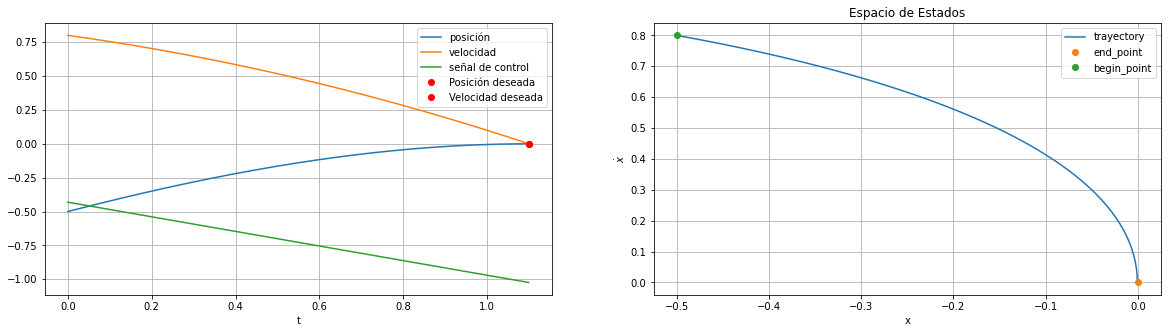

In [30]:
# Graficar el espacio de estados y la señal de control

x = solucion.y[0]
x_dot = solucion.y[1]

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(t,x)
plt.plot(t,x_dot)
plt.plot(t,control_signal_t(control_signal,t,ini_condi,final,tf))
plt.xlabel('t')
plt.grid()
plt.plot(tf,final[0],'ro', tf,final[1],'ro')
plt.legend(['posición','velocidad','señal de control',
            'Posición deseada','Velocidad deseada'])

plt.subplot(1,2,2)
plt.title('Espacio de Estados')
plt.plot(x,x_dot)
plt.xlabel('x')
plt.ylabel('$\dot{x}$')
plt.plot(0,0,'o')
plt.plot(-0.5,0.8,'o')
plt.grid()
plt.legend(['trayectory','end_point', 'begin_point'])

 <a name="chapter6"></a>
## 6. Solución de un problema de control óptimo mediante el mapeo de celdas

Queremos llevar el sistema desde $ x(0) = -0.5, \ \dot{x}(0) = 0.8 $ hasta el punto $x(t_f) = 0, \ \dot{x}(t_f) = 0 $ 
con mínimo esfuerzo de control.

Recordar que los puntos deben estar entre $x_{min} = -2, \ x_{max} = 2, \ y_{min} = -2, \ y_{max} = 2$ y con un espaciamiento de $dx$, $dy$.

In [17]:
# Definir una función para encontrar los caminos más cortos con el criterio de mínimo esfuerzo de control y se redondean los valores de los nodos 
def get_paths(begin_node,end_node):
    begin_node = np.float64(np.round(begin_node,3)) 
    end_node = np.float64(np.round(end_node,1))
    begin_node_str =str(begin_node)
    end_node_str =str(end_node)
    try:
        paths = list(nx.all_shortest_paths(G,begin_node_str,end_node_str,weight='weight'))
        return paths 
    except:
        return None 

# Definir una función para ver cada una de las señales de control aplicadas en el espacio de estados
def secuencia_control(nodes):
    dict_ = []
    for i in range(len(nodes)-1):
        dict_.append(G.get_edge_data(nodes[i],nodes[i+1])['signal'])
    signal =np.array([x for x in dict_])
    return signal

# Definir una función para evaluar la solución de los caminos encontrados (puntos que unen los nodos iniciales y finales) (salida)
# Construir el espacio de estados
def solve_path(x0,signal):
    solucion = np.array([[0],[0]])
    points = []
    for i,u in enumerate(signal):
        tspan=[i*dt,(i+1)*dt]
        t = np.arange(i*dt,(i+1)*dt,0.001)
        sol = solve_ivp(double_integrator,tspan,x0,args=(u,),dense_output=True)
        solucion = np.concatenate((solucion, sol.sol(t)),axis=1)
        x0 = sol.y[:,-1]
        points.append(x0)
        
    return solucion[:,1:], points

In [18]:
begin_node = [-0.5, 0.8] #nodo de inicio
end_node =[0, 0] # nodo final 

In [23]:
paths = get_paths(begin_node,end_node)
nodes = paths[0]

signal = secuencia_control(nodes)
y,points = solve_path(begin_node,signal)

tiempo = len(signal)*dt
total_paths = len(paths)
print (total_paths)
esfuerzo = np.sum(signal**2)*dt

288


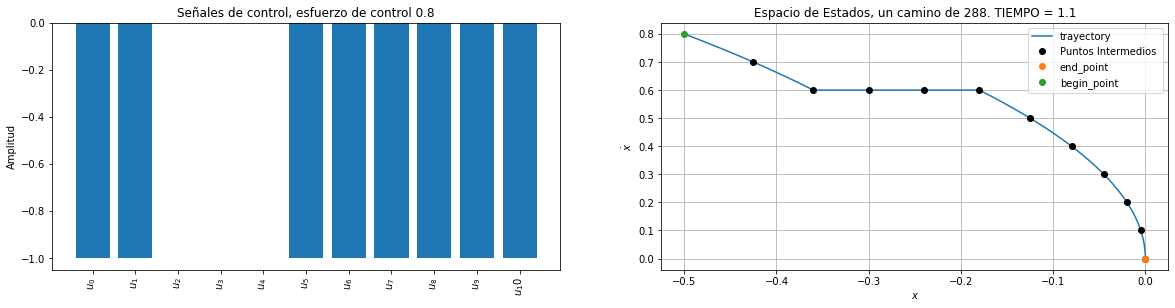

In [31]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.bar(['$u_{}$'.format(i) for i in np.arange(len(signal))],signal,width=0.8)
plt.xticks(rotation = 90)
plt.ylabel('Amplitud')
plt.title('Señales de control, esfuerzo de control {}'.format(esfuerzo))

plt.subplot(2,2,2)
plt.plot(y[0,:],y[1,:])

#puntos intermedios 
plt.plot( np.asarray(points)[:,0], np.asarray(points)[:,1],'ok')

#puntos extremos 
plt.plot(end_node[0],end_node[1],'o')
plt.plot(begin_node[0],begin_node[1],'o')

plt.grid()
plt.xlabel('$x$')
plt.ylabel('$\dot{x}$')
plt.title('Espacio de Estados, un camino de {}. TIEMPO = {}'.format(total_paths,tiempo))
plt.legend(['trayectory','Puntos Intermedios ','end_point', 'begin_point'])


 <a name="chapterr"></a>
## 7. Análisis de los resultados

De las trayectorias del sistema en el espacio de estados en las gráficas de las secciones 5 y 6 se puede ver que al solucionar el mismo problema de control óptimo mediante el método analítico y el de mapeo de celdas se logran cumplir las condiciones finales en el tiempo establecido en ambos casos, a pesar de que las trayectorias no son las mismas. Esto se debe a que para el método analítico no existe ninguna clase de restricción para la magnitud de la señal de control, mientras que para la aproximación numérica mediante el mapeo de celdas se tiene la restricción de que $u$ solo uede tomar valores enteros entre -4 y 4.

Debido a que las señales de control óptimas no son las mismas para la solución del problema mediante los dos métodos y a la gran cantidad de aproximaciones realizadas a la hora de mapear el espacio de estados, la trayectoria de la sección 6 se ve mucho más discretizada que la de la sección 5, que se ve como una curva suave y sin puntos donde se evidencien cambios repentinos. 

 <a name="chapter7"></a>
## 8. Conclusiones y discusión 

El análisis numérico transforma las dificulatades de encontrar la solución analítica de un problema complejo de múltiples dimensiones a necesidades computacionales que pueden ser altas entre más complicado sea el modelo. Para este caso la construcción del grafo requieró un tiempo de computo considerable, y este tiempo solo se hará más grande entre entre más pequeña sea la resolución del espacio, por lo que se hace necesario encontrar un balance entre la fidelidad del modelo numérico y la cantidad de procesamiento computacional que se posea. 

En el ejemplo de aplicación final se pudo observar que se sacrificó considerablemente la fidelidad de las trayectorias en espacio de estados a pesar de que se cumplían con las condiciones finales, iniciales y las restricciones de tiempo y esfuerzo de control, por lo que si se fuera a utilizar esta aproximación en el diseño de un sistema de control real es supremamente importante que se tome en cuenta esta restricción. 

Otra limitación a tomar en cuenta es que a esta aproximación numérica en particular le cuesta más trabajo  converger a la solución cuando las condiciones iniciales y finales están muy separadas, llegando incluso a ocasiones donde no encuentra una trayectoria que cumpla con las condiciones pero que sí tiene solución analítica. Por falta de tiempo no se pudo explorar en este documento cómo arreglar este fallo en el modelo.

Por lo discutido en esta sección se recomienda que para aplicaciones de control óptimo con pocas dimensiones y sencilla aproximación analítica no se utilice el método de mapeo de celdas discutido en este documento.

 <a name="chapter8"></a>
## 9. Referencias
1. [The course page of MEC 560, Optimal control](https://mec560sbu.github.io/2016/09/25/Opt_control/) (2016)
2. [Optimal control of double integrator with minimum total variation, C. Yalçın Kaya](https://www.researchgate.net/publication/330132751_Optimal_control_of_double_integrator_with_minimum_total_variation) (2019)
3. [Introduction into Graph Theory Using Python](https://www.python-course.eu/graphs_python.php) (2011-2020)
4. [Simple cell mapping method for multi-objective optimal feedback control design, ](https://www.researchgate.net/publication/256545819_Simple_cell_mapping_method_for_multi-objective_optimal_feedback_control_design) (2013)
5. [Principles of Optimal Control, MIT OpenCourseWare](https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-323-principles-of-optimal-control-spring-2008/lecture-notes/lec7.pdf) (2008)
6. [Double integrator](https://en.wikipedia.org/wiki/Double_integrator) (2019)
7. [DYNAMICS AND CONTROL. Chapter 17: Optimal Control](http://motion.cs.illinois.edu/RoboticSystems/OptimalControl.html#Optimal-control-problem) ( -- )
8. Cell Mapping Methods: Algorithmic Approaches and Applications (Nonlinear Systems and Complexity) 1st ed. Oliver Schütze, Jian-Qiao Sun, Fu-Rui Xiong, Carlos Hernández (2019)
8. Optimal Control of a Double Integrator, Arturo Locatelli (2016) 
10. Optimal Control Systems (Electrical Engineering Series) 1st Edición, D. Subbaram Naidu (2002)